[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# 에이전트

## 복습

이전 시간에 라우터를 구축했습니다.

* 채팅 모델은 사용자 입력에 따라 도구 호출 여부를 결정합니다
* 조건부 에지를 사용하여 도구를 호출하거나 단순히 종료하는 노드로 라우팅합니다

![](https://i.imgur.com/hOJEzV8.png)

## 목표

이제 이를 일반적인 에이전트 아키텍처로 확장할 수 있습니다.

위 라우터에서 우리는 모델을 호출했고, 모델이 도구를 호출하기로 선택하면 사용자에게 `ToolMessage`를 반환했습니다.
 
하지만 그 `ToolMessage`를 단순히 *모델로 다시 전달*한다면 어떨까요?

모델이 (1) 다른 도구를 호출하거나 (2) 직접 응답하도록 할 수 있습니다.

이것이 일반적인 에이전트 아키텍처인 [ReAct](https://react-lm.github.io/)의 핵심 개념입니다.
  
* `act` - 모델이 특정 도구를 호출하도록 허용 
* `observe` - 도구 출력을 모델로 다시 전달
* `reason` - 모델이 도구 출력을 추론하여 다음 행동(다른 도구 호출 또는 직접 응답)을 결정

이 [범용 아키텍처](https://blog.langchain.dev/planning-for-agents/)는 다양한 유형의 도구에 적용 가능합니다. 

![](https://i.imgur.com/IRLzfZT.png)

In [29]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [30]:
import os, getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

여기서는 [tracing](https://docs.smith.langchain.com/concepts/tracing)을 위해 [LangSmith](https://docs.smith.langchain.com/)를 사용할 것입니다.

우리는 `langchain-academy` 프로젝트에 로그를 기록할 것입니다.

In [31]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [32]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# 이 ipynb에서는 수학 연산이 일반적으로 순차적으로 수행되므로,
# 병렬 도구 호출을 false로 설정했습니다.
# 이번에는 수학 연산을 수행할 수 있는 3개의 도구가 있으며,
# OpenAI 모델은 효율성을 위해 기본적으로 병렬 도구 호출을 사용합니다.
# https://python.langchain.com/docs/how_to/tool_calling_parallel/ 에서
# 직접 시도해 보시고 모델이 수학 방정식을 어떻게 처리하는지 확인해 보세요!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

우리의 대규모 언어 모델(LLM)을 생성하고, 원하는 에이전트 행동의 전반적인 방향을 프롬프트로 제시합시다.

In [33]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="당신은 일련의 입력값에 대해 산술 연산을 수행하는 임무를 맡은 유용한 보조자입니다."
)


# Node
def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [response]}

이전과 마찬가지로 `MessagesState`를 사용하고 도구 목록을 가진 `Tools` 노드를 정의합니다.

`Assistant` 노드는 바인딩된 도구를 가진 모델 자체입니다.

`Assistant`와 `Tools` 노드로 그래프를 생성합니다.

`tools_condition` 에지를 추가합니다. 이 에지는 `Assistant`가 도구를 호출하는지 여부에 따라 `End` 또는 `Tools`로 연결됩니다.

이제 새로운 단계를 하나 추가합니다:

`Tools` 노드를 `Assistant`로 *되돌아가* 연결하여 루프를 형성합니다.

* `assistant` 노드 실행 후, `tools_condition`는 모델 출력이 도구 호출인지 확인합니다.
* 도구 호출인 경우 흐름은 `tools` 노드로 이동합니다.
* `tools` 노드는 `assistant`로 다시 연결됩니다.
* 모델이 도구 호출을 결정하는 한 이 루프는 계속됩니다.
* 모델 응답이 도구 호출이 아닌 경우 흐름은 END로 이동하여 프로세스를 종료합니다.

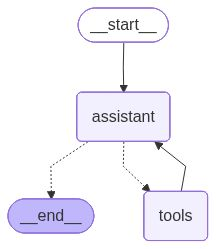

In [34]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [
    HumanMessage(
        content="3과 4를 더하십시오. 출력값에 2를 곱하십시오. 출력값을 5로 나누십시오."
    )
]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하십시오. 출력값에 2를 곱하십시오. 출력값을 5로 나누십시오.
================================== Ai Message ==================================
Tool Calls:
  add (call_x470bUeeCie22lV7qGqAcDT4)
 Call ID: call_x470bUeeCie22lV7qGqAcDT4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_n39N7AAlLXxXKuW2km9IEaNg)
 Call ID: call_n39N7AAlLXxXKuW2km9IEaNg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_As2fVsP8iij30QV694m2qv7z)
 Call ID: call_As2fVsP8iij30QV694m2qv7z
  Args:
    a: 14
    b: 5
================================= Tool Message =================================


## LangSmith
LangSmith에서 traces을 살펴볼 수 있습니다.